


**Cross validation for CNN model**



Cross-validation for age model:



Cross-validation for gender model:


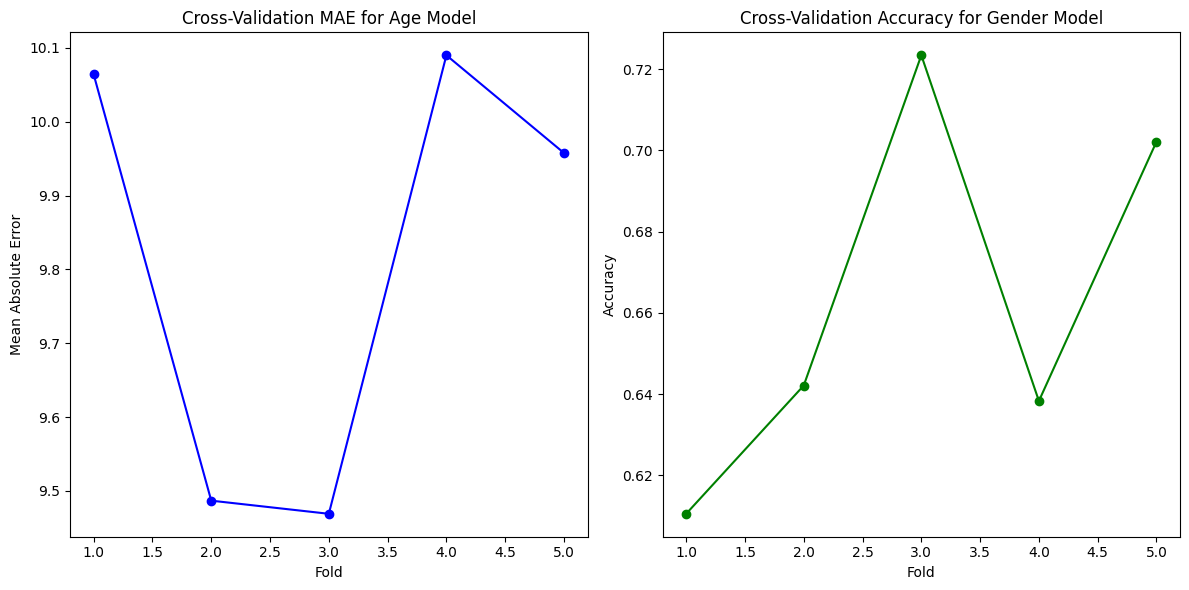


Age Model Mean MAE: 9.8135009765625
Gender Model Mean Accuracy: 0.6632922649383545


In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# Function to load images and labels from the dataset
def load_images_from_folder(folder):
    images = []
    age_labels = []
    gender_labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (224, 224))
            age, gender = map(int, filename.split('_')[:2])
            images.append(img)
            age_labels.append(age)
            gender_labels.append(gender)
    return images, age_labels, gender_labels

# Set the path to your dataset and load data
folder_path = '/content/drive/MyDrive/Family/500'  # Update this path
images, age_labels, gender_labels = load_images_from_folder(folder_path)

# Convert data to numpy arrays and normalize
images = np.array(images, dtype='float32') / 255.0
age_labels = np.array(age_labels)
gender_labels = np.array(gender_labels)

# Define the CNN model for age detection
def build_age_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Define the CNN model for gender detection
def build_gender_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation configuration
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
age_mae_scores = []
gender_accuracy_scores = []

# Perform cross-validation for age model
print("Cross-validation for age model:")
for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = age_labels[train_index], age_labels[test_index]

    age_model = build_age_model()
    age_model.fit(X_train, y_train, epochs=10, verbose=0)
    _, mae = age_model.evaluate(X_test, y_test, verbose=0)
    age_mae_scores.append(mae)

# Perform cross-validation for gender model
print("\nCross-validation for gender model:")
for train_index, test_index in kf.split(images):
    X_train, X_test = images[train_index], images[test_index]
    y_train, y_test = gender_labels[train_index], gender_labels[test_index]

    gender_model = build_gender_model()
    gender_model.fit(X_train, y_train, epochs=10, verbose=0)
    _, accuracy = gender_model.evaluate(X_test, y_test, verbose=0)
    gender_accuracy_scores.append(accuracy)

# Plotting the results
plt.figure(figsize=(12, 6))

# Plotting MAE for Age Model
plt.subplot(1, 2, 1)
plt.plot(range(1, 6), age_mae_scores, marker='o', color='blue')
plt.title('Cross-Validation MAE for Age Model')
plt.xlabel('Fold')
plt.ylabel('Mean Absolute Error')

# Plotting Accuracy for Gender Model
plt.subplot(1, 2, 2)
plt.plot(range(1, 6), gender_accuracy_scores, marker='o', color='green')
plt.title('Cross-Validation Accuracy for Gender Model')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Print mean scores
print(f"\nAge Model Mean MAE: {np.mean(age_mae_scores)}")
print(f"Gender Model Mean Accuracy: {np.mean(gender_accuracy_scores)}")


**Implementation of YOLO with CNN**

In [ ]:
import numpy as np
import cv2
import os
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load YOLO model from torch hub
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Preprocess images for YOLO and extract faces
def preprocess_image_yolo(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return []
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = yolo_model(img)
    faces = results.crop(save=False)
    return [face['im'] for face in faces]

# Extract age and gender from filename
def extract_label(filename):
    try:
        parts = filename.split('_')
        age = int(parts[0])
        gender = int(parts[1])
        return age, gender
    except ValueError:
        # Skip files that don't have the expected format
        print(f"Skipping file with unexpected format: {filename}")
        return None, None

# Load images and labels from dataset
def load_images_and_labels(folder):
    images, ages, genders = [], [], []
    for filename in os.listdir(folder):
        age_gender = extract_label(filename)
        if age_gender is None:
            continue  # Skip files with unexpected format
        age, gender = age_gender
        filepath = os.path.join(folder, filename)
        detected_faces = preprocess_image_yolo(filepath)
        for face in detected_faces:
            face_resized = cv2.resize(face, (224, 224))
            images.append(face_resized)
            ages.append(age)
            genders.append(gender)
    return np.array(images), np.array(ages), np.array(genders)

# Path to your dataset
dataset_path = '/content/drive/MyDrive/JGGH'
images, ages, genders = load_images_and_labels(dataset_path)

# Split data
X_train, X_test, y_train_age, y_test_age = train_test_split(images, ages, test_size=0.2, random_state=42)
_, _, y_train_gender, y_test_gender = train_test_split(images, genders, test_size=0.2, random_state=42)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Build CNN for age prediction
def build_age_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1)  # Regression output
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

# Build CNN for gender prediction
def build_gender_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')  # Binary classification output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create model instances
age_model = build_age_model()
gender_model = build_gender_model()

# Train models with validation data
age_history = age_model.fit(datagen.flow(X_train, y_train_age, batch_size=32), validation_data=(X_test, y_test_age), epochs=30)
gender_history = gender_model.fit(datagen.flow(X_train, y_train_gender, batch_size=32), validation_data=(X_test, y_test_gender), epochs=30)

# Evaluate models
age_loss, age_mae = age_model.evaluate(X_test, y_test_age)
gender_loss, gender_accuracy = gender_model.evaluate(X_test, y_test_gender)


print(f'Age model MAE: {age_mae}')
print(f'Gender model accuracy: {gender_accuracy}')

# Save the trained models
age_model_save_path = '/content/drive/MyDrive/JGGH/age_model.h5'
gender_model_save_path = '/content/drive/MyDrive/JGGH/gender_model.h5'

age_model.save(age_model_save_path)
gender_model.save(gender_model_save_path)

print("Models saved successfully.")




/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 238.4 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 9.4.0
    Uninstalling Pillow-9.4.0:
      Successfully uninstalled Pillow-9.4.0

requirements: AutoUpdate success ✅ 9.8s, installed 2 packages: ['gitpython>=3.1.30', 'Pillow>=10.0.1']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



YOLOv5 🚀 2023-12-1 Python-3.10.12 torch-2.1.0+cu118 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 108MB/s] 

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Skipping file with unexpected format: age_model.h5
Skipping file with unexpected format: gender_model.h5
Epoch 1/30
38/38 [==============================] - 170s 4s/step - loss: 80860.8438 - mae: 80.1757 - val_loss: 478.5523 - val_mae: 16.4637
Epoch 2/30
38/38 [==============================] - 174s 5s/step - loss: 676.8248 - mae: 19.7957 - val_loss: 455.8059 - val_mae: 15.9292
Epoch 3/30
38/38 [==============================] - 175s 5s/step - loss: 598.1556 - mae: 18.1586 - val_loss: 441.3056 - val_mae: 15.8188
Epoch 4/30
38/38 [==============================] - 167s 4s/step - loss: 607.7391 - mae: 18.5556 - val_loss: 450.4073 - val_mae: 15.7377
Epoch 5/30
38/38 [==============================] - 174s 5s/step - loss: 604.2079 - mae: 18.5298 - val_loss: 475.6487 - val_mae: 16.0756
Epoch 6/30
38/38 [==============================] - 167s 4s/step - loss: 608.5327 - mae: 18.5212 - val_loss: 445.6995 - val_mae: 15.6914
Epoch 7/30
38/38 [==============================] - 178s 5s/step - loss

In [ ]:
print(age_history.history.keys())
print(gender_history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


**Accuracy testing of YOLO**

In [ ]:
age_test_loss, age_test_mae = age_model.evaluate(X_test, y_test_age, verbose=0)
gender_test_loss, gender_test_accuracy = gender_model.evaluate(X_test, y_test_gender, verbose=0)
print("Age Test MAE:", age_test_mae)
print("Gender Test Accuracy:", gender_test_accuracy)

Age Test MAE: 16.879867553710938
Gender Test Accuracy: 0.6336633563041687


**Graph line**

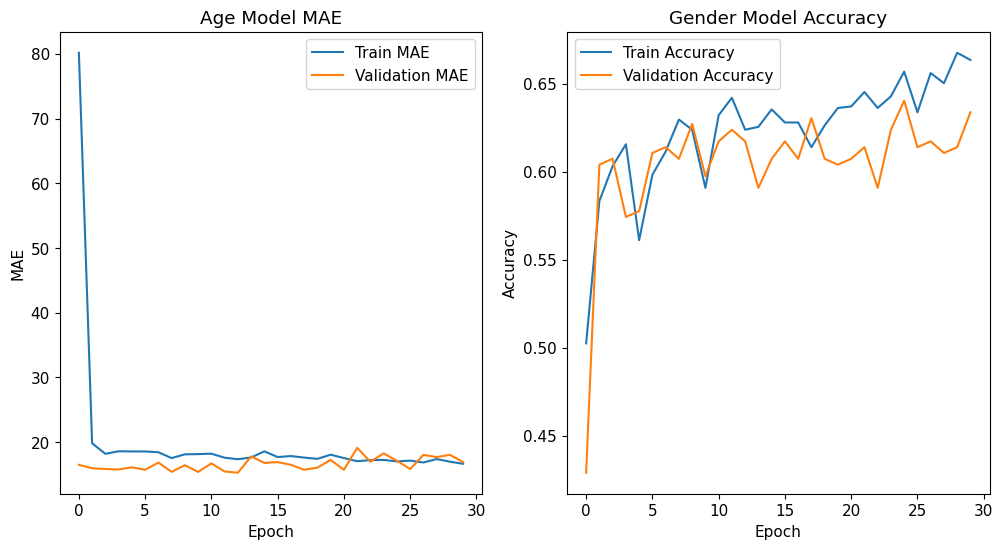

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting Age Model MAE
plt.subplot(1, 2, 1)
plt.plot(age_history.history['mae'], label='Train MAE')
plt.plot(age_history.history['val_mae'], label='Validation MAE')
plt.title('Age Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Plotting Gender Model Accuracy
plt.subplot(1, 2, 2)
plt.plot(gender_history.history['accuracy'], label='Train Accuracy')
plt.plot(gender_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Gender Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Sample image testing with YOLO**

In [3]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Paths to your saved models
age_model_path = '/content/drive/MyDrive/JGGH/age_model.h5'
gender_model_path = '/content/drive/MyDrive/JGGH/gender_model.h5'
emotion_model_path = '/content/drive/MyDrive/emotion_little_vgg_2.h5'  # Update with the correct path

# Load the models
age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)
emotion_model = load_model(emotion_model_path)  # Load the emotion classifier model

def preprocess_image(image_path, size=(224, 224), color_mode='rgb'):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE if color_mode == 'grayscale' else cv2.IMREAD_COLOR)
    if img is None:
        print(f"Failed to load image: {image_path}")
        return None
    img = cv2.resize(img, size)
    img = img / 255.0
    if color_mode == 'grayscale':
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for grayscale
    return img.reshape(1, *size, img.shape[-1])

# Example usage
test_image_path = '/content/drive/MyDrive/1000/12_1_2_20170116194059753.jpg'
processed_image = preprocess_image(test_image_path)  # For age and gender
emotion_image = preprocess_image(test_image_path, size=(48, 48), color_mode='grayscale')  # For emotion

# Predict age
predicted_age = age_model.predict(processed_image)
print(f"Predicted Age: {predicted_age[0][0]}")

# Predict gender
predicted_gender_prob = gender_model.predict(processed_image)
predicted_gender = "Male" if predicted_gender_prob[0][0] < 0.5 else "Female"
print(f"Predicted Gender: {predicted_gender}")

# Predict emotion
predicted_emotion_prob = emotion_model.predict(emotion_image)
predicted_emotion = np.argmax(predicted_emotion_prob, axis=1)
emotion_labels = ['Happy', 'Sad', 'Angry', 'Surprise', 'Fear' , 'Neutral']  # Update with your actual labels
predicted_emotion_label = emotion_labels[predicted_emotion[0]]
print(f"Predicted Emotion: {predicted_emotion_label}")


1/1 [==============================] - 0s 113ms/step
Predicted Age: 3.873379945755005
1/1 [==============================] - 0s 114ms/step
Predicted Gender: Male
1/1 [==============================] - 0s 282ms/step
Predicted Emotion: Surprise


**Evalution metrices for YOLO**

In [1]:
import numpy as np
import cv2
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to load images and labels from the dataset for testing
def load_images_from_folder(folder, img_size=(224, 224)):
    images = []
    age_labels = []
    gender_labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            images.append(img)
            # Extracting the age and gender from the filename
            age, gender = filename.split('_')[0:2]
            age_labels.append(int(age))
            gender_labels.append(int(gender))
    # Convert lists to numpy arrays and normalize the images
    images = np.array(images, dtype='float32') / 255.0
    age_labels = np.array(age_labels)
    gender_labels = np.array(gender_labels)
    return images, age_labels, gender_labels

# Load the test data
test_data_folder = "/content/drive/MyDrive/JGGH"  # Update this path
X_test, y_test_age, y_test_gender = load_images_from_folder(test_data_folder)

# Load the saved models
age_model = load_model('/content/drive/MyDrive/JGGH/age_model.h5')
gender_model = load_model('/content/drive/MyDrive/JGGH/gender_model.h5')

# Evaluate the models on the test data
age_test_loss, age_test_mae = age_model.evaluate(X_test, y_test_age)
gender_test_loss, gender_test_acc = gender_model.evaluate(X_test, y_test_gender)

# Predicting age and gender
predicted_ages = age_model.predict(X_test).flatten()
predicted_genders = gender_model.predict(X_test)
predicted_genders = (predicted_genders > 0.5).astype(int)

# Classification report for gender prediction
print(classification_report(y_test_gender, predicted_genders, target_names=['Male', 'Female']))

# RMSE for age prediction
age_rmse = np.sqrt(mean_squared_error(y_test_age, predicted_ages))
print('Age Prediction RMSE:', age_rmse)



34/34 [==============================] - 38s 1s/step
              precision    recall  f1-score   support

        Male       0.49      0.91      0.63       510
      Female       0.61      0.12      0.21       563

    accuracy                           0.50      1073
   macro avg       0.55      0.52      0.42      1073
weighted avg       0.55      0.50      0.41      1073

Age Prediction RMSE: 36.07208793063737
